Dataset Shape: (569, 31)

Feature Names:
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target Names: ['malignant' 'benign']

=== Basic Statistics ===
       mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
count       569.00        569.00          569.00     569.00           569.00   
mean         14.13         19.29           91.97     654.89             0.10   
std           3.52          4.30           24.30     351.91             0.01   
min           6.98 

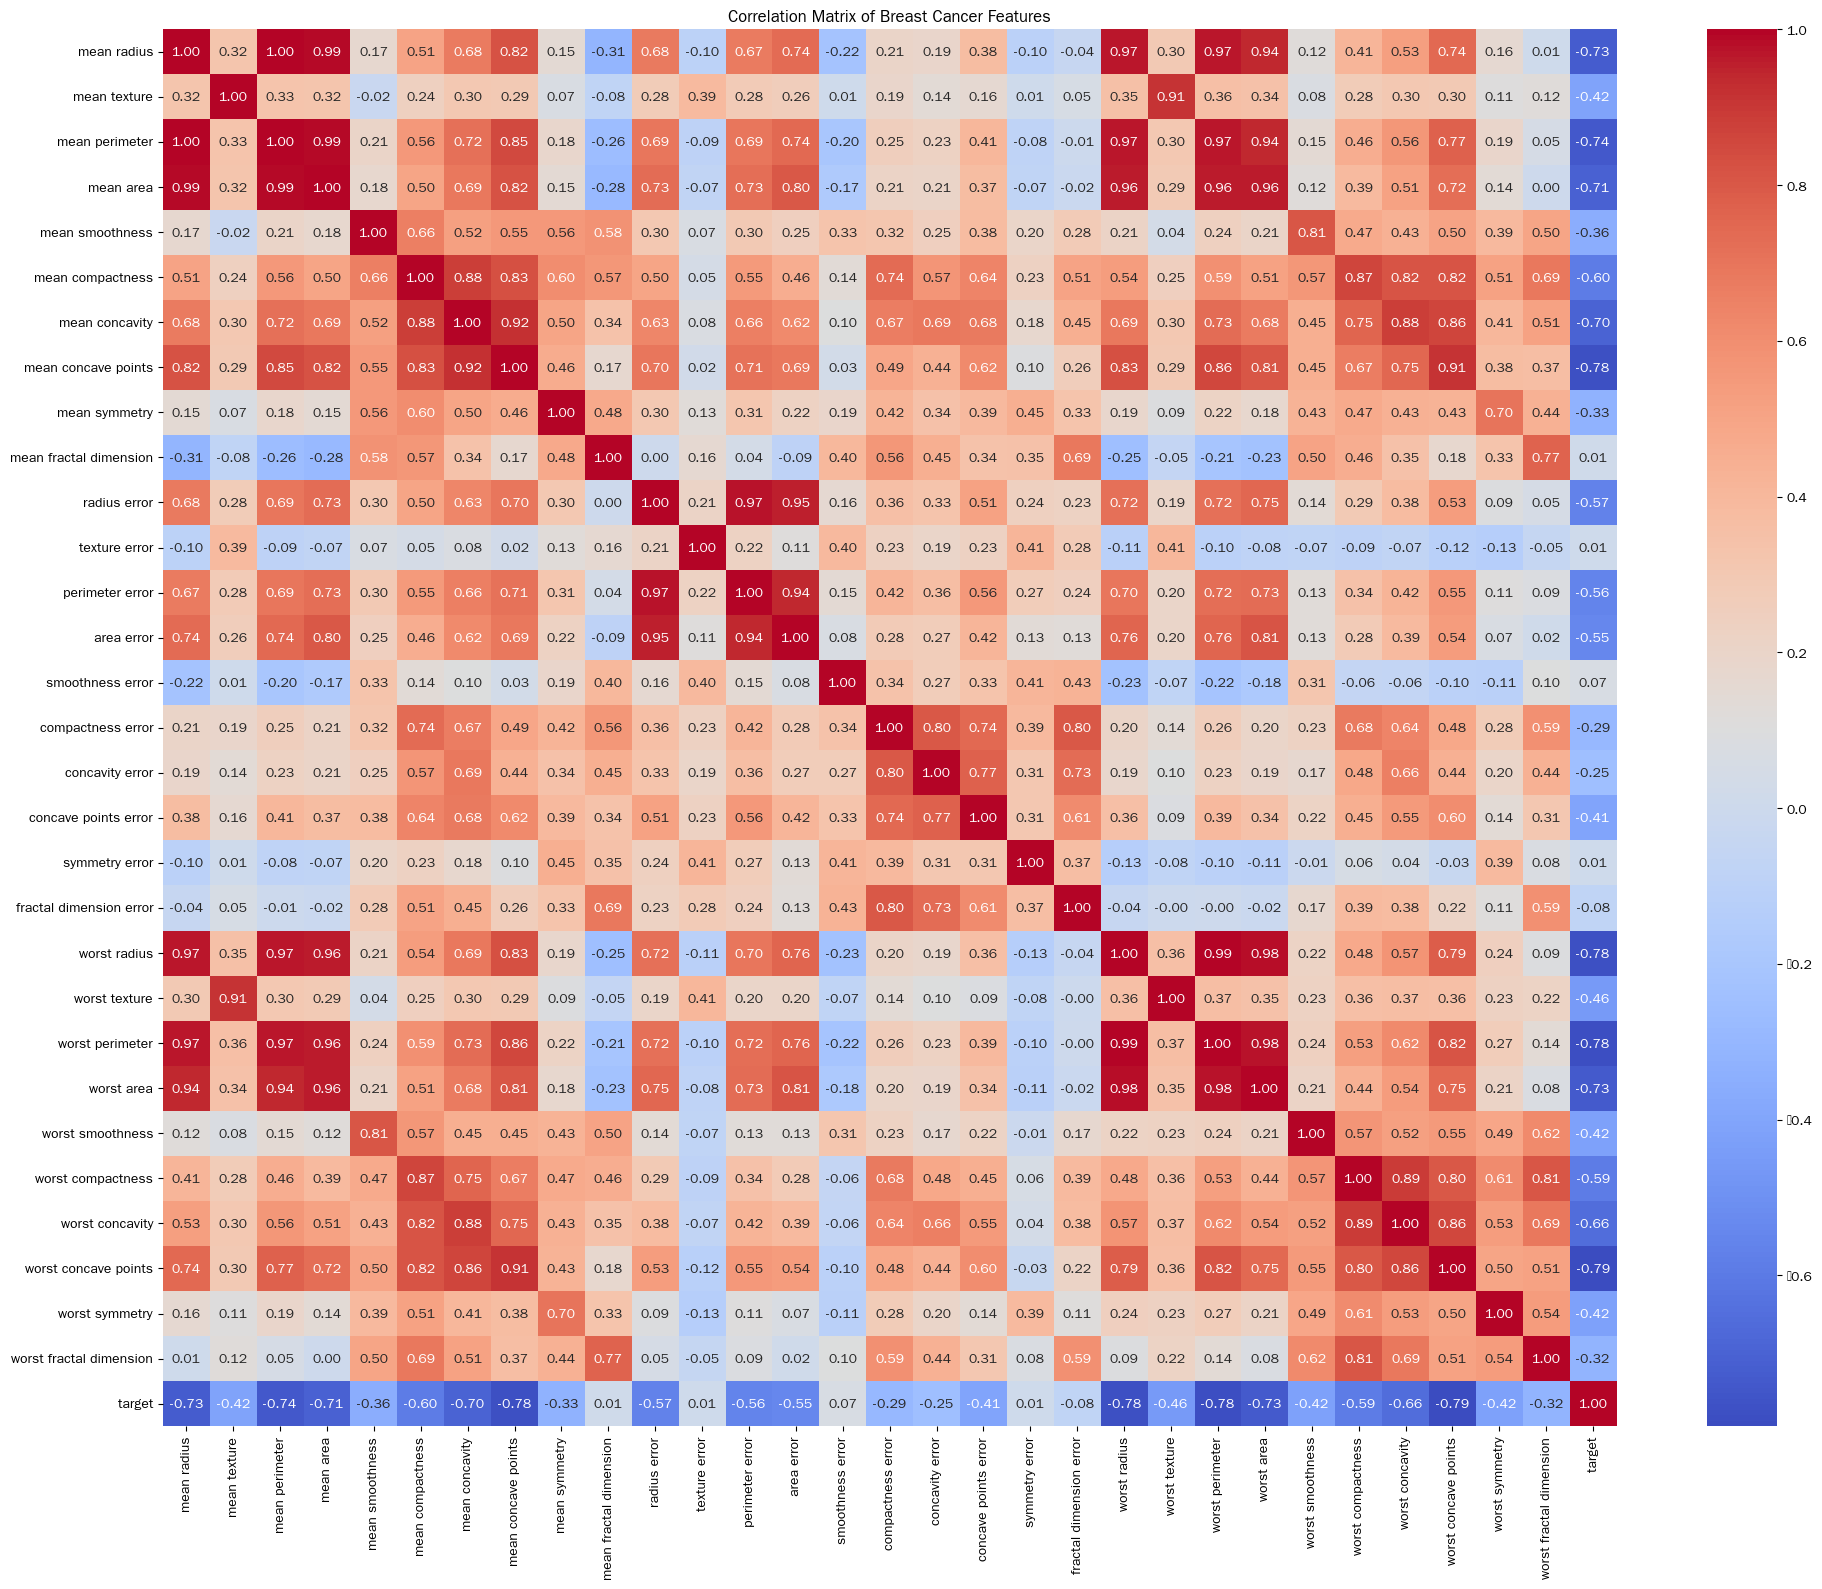

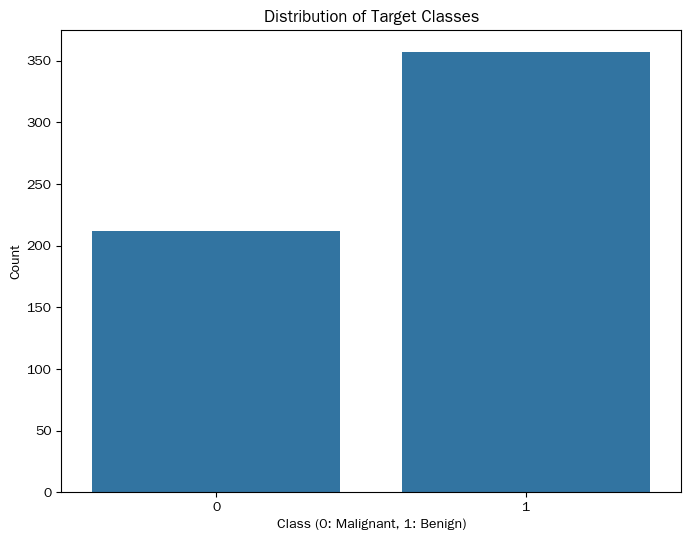

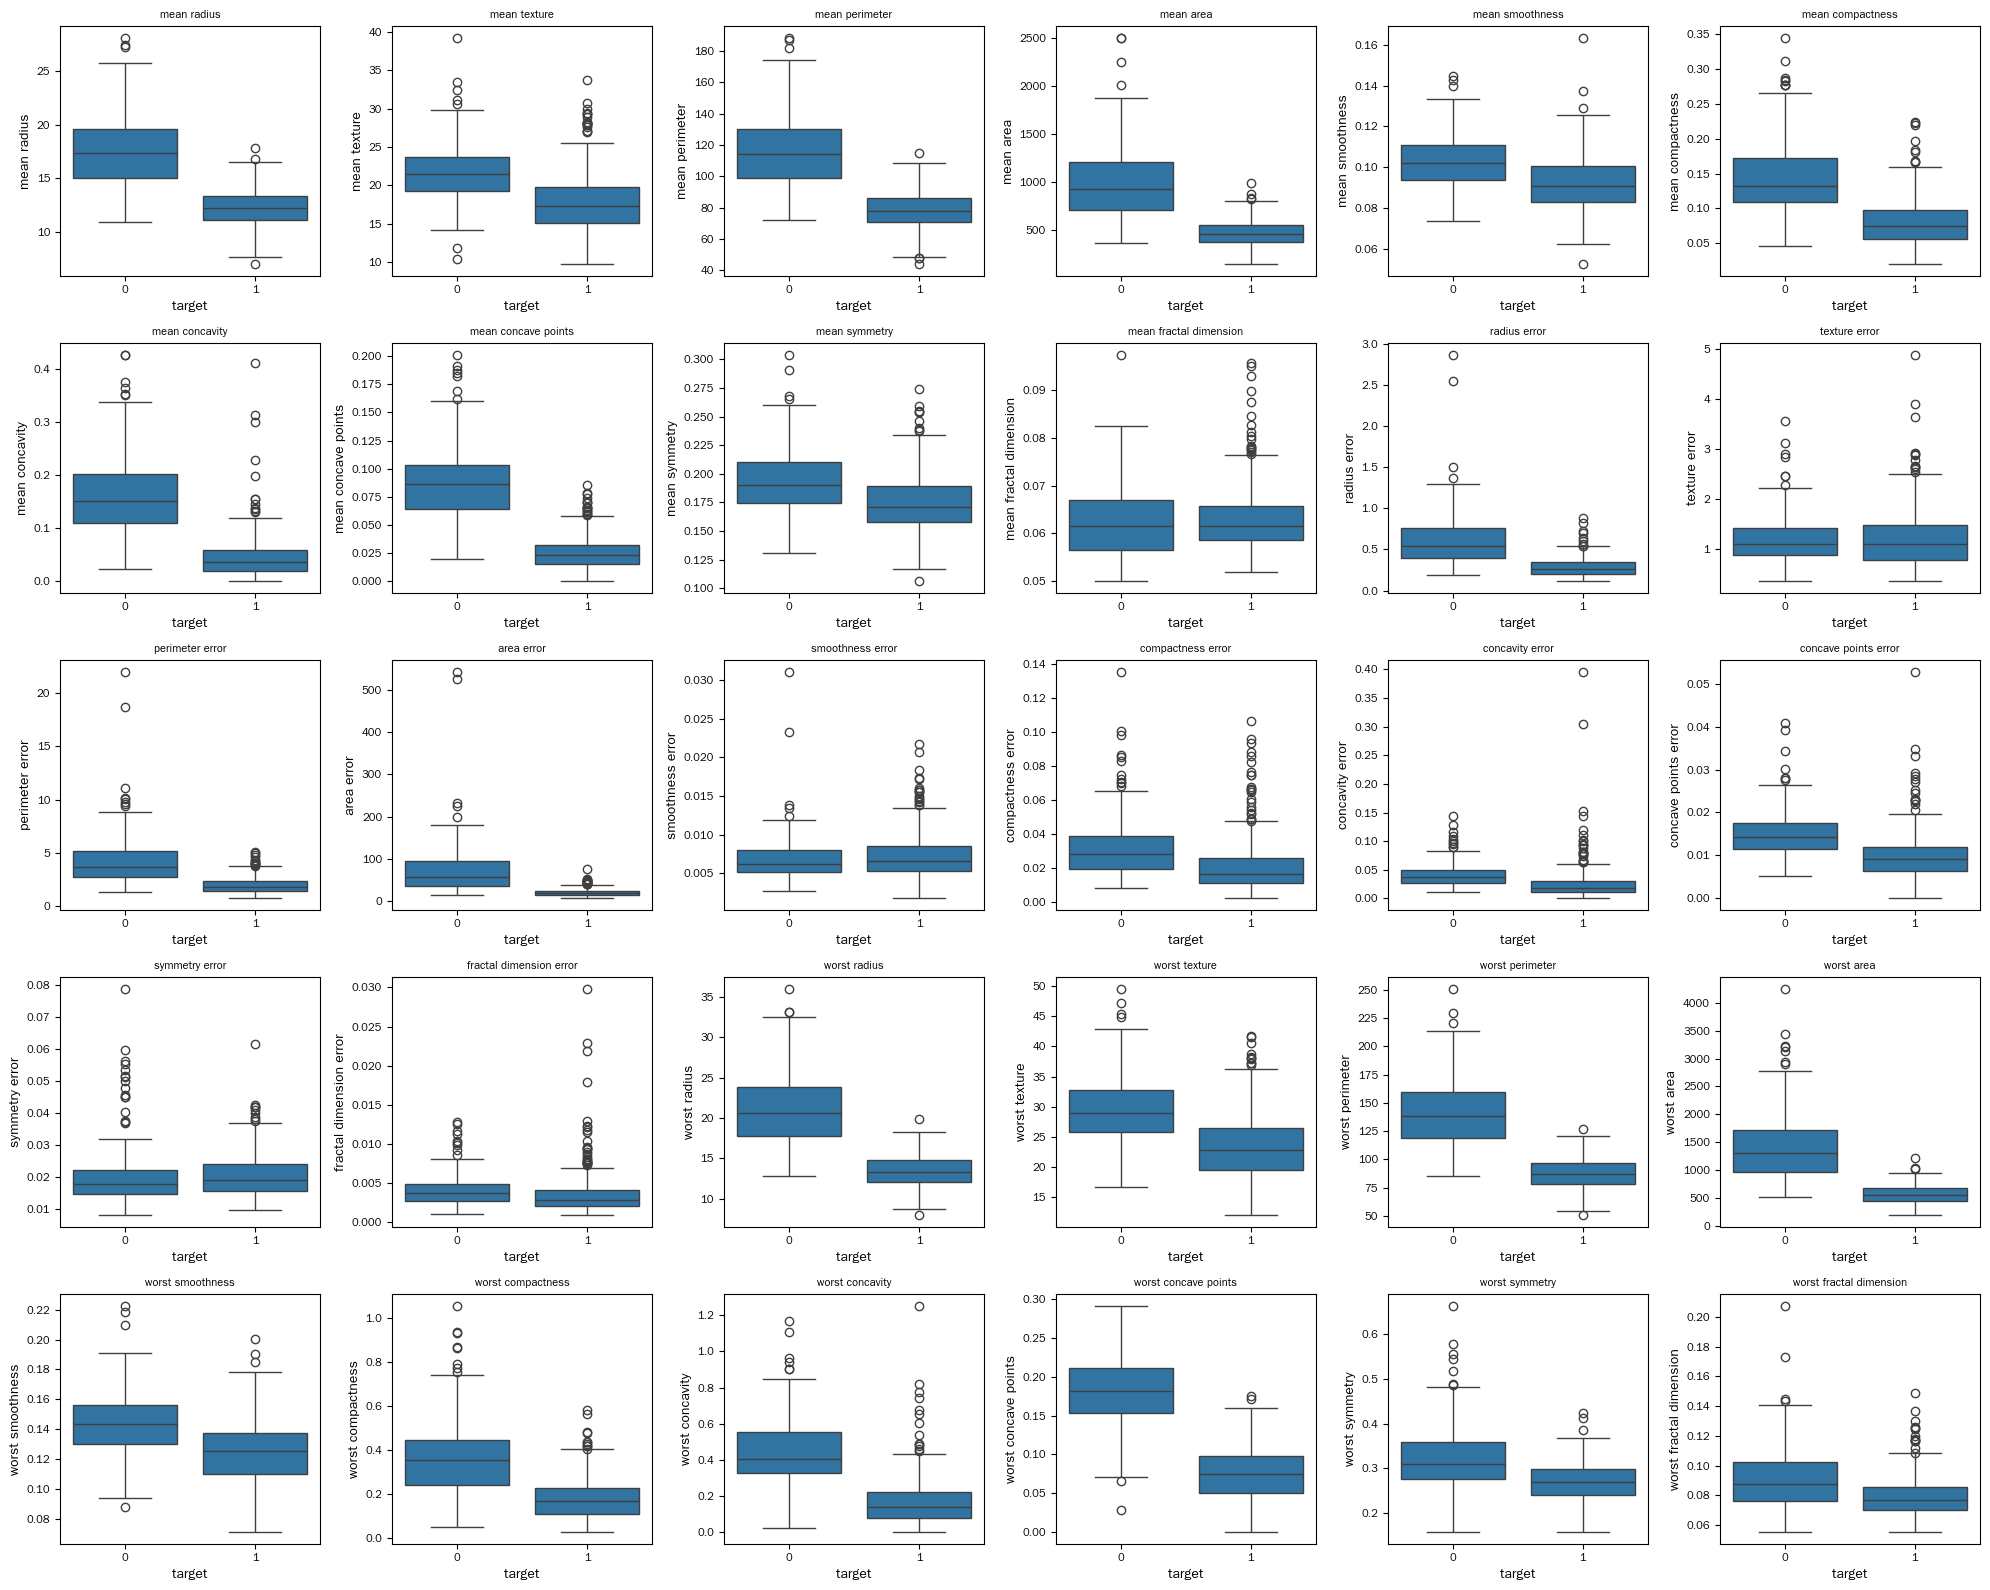

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFeature Names:\n", data.feature_names)
print("\nTarget Names:", data.target_names)
print("\n=== Basic Statistics ===")
print(df.describe().round(2))

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Create correlation matrix visualization
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Breast Cancer Features')
plt.tight_layout()

# Distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Classes')
plt.xlabel('Class (0: Malignant, 1: Benign)')
plt.ylabel('Count')

# Feature distributions by class
fig, axes = plt.subplots(5, 6, figsize=(20, 16))
axes = axes.ravel()

for idx, feature in enumerate(data.feature_names):
    if idx < 30:  # We have 30 features
        sns.boxplot(data=df, x='target', y=feature, ax=axes[idx])
        axes[idx].set_title(feature, fontsize=8)
        axes[idx].tick_params(labelsize=8)
plt.tight_layout()

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('target', axis=1))
df_scaled = pd.DataFrame(scaled_features, columns=data.feature_names)
df_scaled['target'] = df['target']

# Save preprocessed data
import os
save_dir = '/data/chats/4dmnj/workspace/breast_cancer_analysis'
os.makedirs(save_dir, exist_ok=True)
df_scaled.to_csv(f'{save_dir}/preprocessed_data.csv', index=False)

print("\nPreprocessed data has been saved to:", f'{save_dir}/preprocessed_data.csv')

# Display first few rows of scaled data
print("\n=== First few rows of scaled data ===")
print(df_scaled.head())

In [2]:
from metagpt.tools.libs.data_preprocess import get_column_info

column_info = get_column_info(df_scaled)
print("column_info")
print(column_info)

column_info
{'Category': [], 'Numeric': ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target'], 'Datetime': [], 'Others': []}


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

# Load the scaled data
X = df_scaled.drop('target', axis=1)
y = df_scaled['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
start_time = time.time()
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the random search
random_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Get best model
best_rf = random_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')

# Make predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Create visualizations directory
viz_dir = f'{save_dir}/visualizations'
os.makedirs(viz_dir, exist_ok=True)

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.savefig(f'{viz_dir}/rf_roc_curve.png')
plt.close()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'{viz_dir}/rf_confusion_matrix.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig(f'{viz_dir}/rf_feature_importance.png')
plt.close()

# Save results
results = {
    'best_parameters': random_search.best_params_,
    'cross_validation_scores': {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    },
    'test_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc
    },
    'training_time': training_time
}

# Save model and results
joblib.dump(best_rf, f'{save_dir}/random_forest_model.joblib')
with open(f'{save_dir}/rf_results.txt', 'w') as f:
    f.write('Random Forest Classification Results\n')
    f.write('===================================\n\n')
    f.write(f'Best Parameters:\n{results["best_parameters"]}\n\n')
    f.write(f'Cross-validation F1 scores:\nMean: {results["cross_validation_scores"]["mean"]:.3f}\n')
    f.write(f'Std: {results["cross_validation_scores"]["std"]:.3f}\n\n')
    f.write('Test Metrics:\n')
    f.write(f'Accuracy: {results["test_metrics"]["accuracy"]:.3f}\n')
    f.write(f'Precision: {results["test_metrics"]["precision"]:.3f}\n')
    f.write(f'Recall: {results["test_metrics"]["recall"]:.3f}\n')
    f.write(f'F1-score: {results["test_metrics"]["f1_score"]:.3f}\n')
    f.write(f'AUC-ROC: {results["test_metrics"]["auc_score"]:.3f}\n\n')
    f.write(f'Training Time: {results["training_time"]:.2f} seconds\n')

print("Random Forest Classification Results:")
print(f"Best Parameters: {random_search.best_params_}")
print(f"\nCross-validation F1 scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print(f"\nTest Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC-ROC: {auc:.3f}")
print(f"\nTraining Time: {training_time:.2f} seconds")
print(f"\nResults and visualizations saved in {save_dir}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest Classification Results:
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 50, 'class_weight': 'balanced'}

Cross-validation F1 scores: 0.972 (+/- 0.023)

Test Metrics:
Accuracy: 0.939
Precision: 0.958
Recall: 0.944
F1-score: 0.951
AUC-ROC: 0.992

Training Time: 88.69 seconds

Results and visualizations saved in /data/chats/4dmnj/workspace/breast_cancer_analysis


In [4]:
from metagpt.tools.libs.data_preprocess import get_column_info

column_info = get_column_info(df_scaled)
print("column_info")
print(column_info)

# Also print key model performance metrics for reference
print("\nKey Model Performance Metrics:")
print(f"Best Model Accuracy: {accuracy:.3f}")
print(f"Best Model F1-Score: {f1:.3f}")
print(f"Best Model AUC-ROC: {auc:.3f}")

# Print top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

column_info
{'Category': [], 'Numeric': ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target'], 'Datetime': [], 'Others': []}

Key Model Performance Metrics:
Best Model Accuracy: 0.939
Best Model F1-Score: 0.951
Best Model AUC-ROC: 0.992

Top 5 Most Important Features:
                 feature  importance
22       worst perimeter    0.133361
23            worst area    0.132470
27  worst concave points    0.103831
7    mean concave points    0.083502
20          wo

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import time

# Use existing X, y and train-test split from previous code
print("Starting Decision Tree Classification optimization...\n")

# Define parameter grid for comprehensive tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]  # Cost-Complexity Pruning parameter
}

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Create custom scorer that combines multiple metrics
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'auc': 'roc_auc'
}

# Perform Grid Search with cross-validation
start_time = time.time()
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='f1',  # Use F1 score to select the best model
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Get best model
best_dt = grid_search.best_estimator_

# Make predictions
y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Perform cross-validation on best model
cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='f1')

# Create visualizations
# 1. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.savefig(f'{viz_dir}/dt_roc_curve.png')
plt.close()

# 2. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'{viz_dir}/dt_confusion_matrix.png')
plt.close()

# 3. Feature Importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig(f'{viz_dir}/dt_feature_importance.png')
plt.close()

# 4. Tree Visualization (limited depth for visibility)
plt.figure(figsize=(20, 10))
plot_tree(best_dt, max_depth=3, feature_names=X.columns, 
          class_names=['malignant', 'benign'], 
          filled=True, rounded=True)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.savefig(f'{viz_dir}/dt_structure.png', dpi=300, bbox_inches='tight')
plt.close()

# Save detailed tree structure as text
tree_text = export_text(best_dt, feature_names=list(X.columns))
with open(f'{save_dir}/dt_structure.txt', 'w') as f:
    f.write(tree_text)

# Save results
results = {
    'best_parameters': grid_search.best_params_,
    'cross_validation_scores': {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    },
    'test_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc
    },
    'training_time': training_time
}

# Save model and results
joblib.dump(best_dt, f'{save_dir}/decision_tree_model.joblib')
with open(f'{save_dir}/dt_results.txt', 'w') as f:
    f.write('Decision Tree Classification Results\n')
    f.write('===================================\n\n')
    f.write(f'Best Parameters:\n{results["best_parameters"]}\n\n')
    f.write(f'Cross-validation F1 scores:\nMean: {results["cross_validation_scores"]["mean"]:.3f}\n')
    f.write(f'Std: {results["cross_validation_scores"]["std"]:.3f}\n\n')
    f.write('Test Metrics:\n')
    f.write(f'Accuracy: {results["test_metrics"]["accuracy"]:.3f}\n')
    f.write(f'Precision: {results["test_metrics"]["precision"]:.3f}\n')
    f.write(f'Recall: {results["test_metrics"]["recall"]:.3f}\n')
    f.write(f'F1-score: {results["test_metrics"]["f1_score"]:.3f}\n')
    f.write(f'AUC-ROC: {results["test_metrics"]["auc_score"]:.3f}\n\n')
    f.write(f'Training Time: {results["training_time"]:.2f} seconds\n')

print("Decision Tree Classification Results:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"\nCross-validation F1 scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print(f"\nTest Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC-ROC: {auc:.3f}")
print(f"\nTraining Time: {training_time:.2f} seconds")
print(f"\nResults and visualizations saved in {save_dir}")

Starting Decision Tree Classification optimization...

Fitting 5 folds for each of 8064 candidates, totalling 40320 fits
Decision Tree Classification Results:
Best Parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}

Cross-validation F1 scores: 0.963 (+/- 0.019)

Test Metrics:
Accuracy: 0.912
Precision: 0.943
Recall: 0.917
F1-score: 0.930
AUC-ROC: 0.932

Training Time: 212.44 seconds

Results and visualizations saved in /data/chats/4dmnj/workspace/breast_cancer_analysis


In [6]:
from metagpt.tools.libs.data_preprocess import get_column_info

# Check the scaled DataFrame which was used for modeling
column_info = get_column_info(df_scaled)
print("Scaled DataFrame Column Info:")
print(column_info)

# Print shapes of key train-test split variables
print("\nKey Dataset Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print best model performances
print("\nModel Performance Comparison:")
print("Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, best_rf.predict(X_test)):.3f}")
print(f"F1-Score: {f1_score(y_test, best_rf.predict(X_test)):.3f}")

print("\nDecision Tree:")
print(f"Accuracy: {accuracy_score(y_test, best_dt.predict(X_test)):.3f}")
print(f"F1-Score: {f1_score(y_test, best_dt.predict(X_test)):.3f}")

Scaled DataFrame Column Info:
{'Category': [], 'Numeric': ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target'], 'Datetime': [], 'Others': []}

Key Dataset Shapes:
X_train shape: (455, 30)
X_test shape: (114, 30)
y_train shape: (455,)
y_test shape: (114,)

Model Performance Comparison:
Random Forest:
Accuracy: 0.939
F1-Score: 0.951

Decision Tree:
Accuracy: 0.912
F1-Score: 0.930


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import matplotlib.pyplot as plt
import time

# Use scaled features without target
X_for_clustering = df_scaled.drop('target', axis=1)

# Find optimal number of clusters using elbow method and silhouette analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
elbow = KElbowVisualizer(KMeans(random_state=42), k=(2, 10), ax=ax1)
elbow.fit(X_for_clustering)
optimal_k = elbow.elbow_value_

# Silhouette Analysis
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_clustering)
    silhouette_scores.append(silhouette_score(X_for_clustering, kmeans.labels_))

ax2.plot(K, silhouette_scores, 'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs. Number of Clusters')
plt.tight_layout()
plt.savefig(f'{viz_dir}/kmeans_optimal_k.png')
plt.close()

# Train final K-means model with optimal k
start_time = time.time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_for_clustering)
training_time = time.time() - start_time

# Calculate silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_for_clustering, cluster_labels)

# Visualize clustering results using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_clustering)

# Plot clustering results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'K-means Clustering Results (k={optimal_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig(f'{viz_dir}/kmeans_clusters.png')
plt.close()

# Compare clusters with actual labels
comparison_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'Actual_Label': df_scaled['target']
})

cluster_label_distribution = pd.crosstab(
    comparison_df['Cluster'], 
    comparison_df['Actual_Label'],
    normalize='index'
) * 100

# Calculate clustering metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari_score = adjusted_rand_score(df_scaled['target'], cluster_labels)
ami_score = adjusted_mutual_info_score(df_scaled['target'], cluster_labels)
avg_silhouette = silhouette_score(X_for_clustering, cluster_labels)

# Save results
results = {
    'optimal_k': optimal_k,
    'metrics': {
        'adjusted_rand_index': ari_score,
        'adjusted_mutual_info': ami_score,
        'silhouette_score': avg_silhouette
    },
    'training_time': training_time,
    'explained_variance_ratio': pca.explained_variance_ratio_
}

# Save model and results
joblib.dump(kmeans, f'{save_dir}/kmeans_model.joblib')

with open(f'{save_dir}/kmeans_results.txt', 'w') as f:
    f.write('K-means Clustering Results\n')
    f.write('========================\n\n')
    f.write(f'Optimal number of clusters (k): {optimal_k}\n\n')
    f.write('Clustering Metrics:\n')
    f.write(f'Silhouette Score: {results["metrics"]["silhouette_score"]:.3f}\n')
    f.write(f'Adjusted Rand Index: {results["metrics"]["adjusted_rand_index"]:.3f}\n')
    f.write(f'Adjusted Mutual Information: {results["metrics"]["adjusted_mutual_info"]:.3f}\n\n')
    f.write('PCA Explained Variance Ratio:\n')
    f.write(f'First component: {results["explained_variance_ratio"][0]:.3f}\n')
    f.write(f'Second component: {results["explained_variance_ratio"][1]:.3f}\n\n')
    f.write(f'Training Time: {results["training_time"]:.2f} seconds\n\n')
    f.write('Cluster Label Distribution (%):\n')
    f.write(cluster_label_distribution.to_string())

print("K-means Clustering Results:")
print(f"Optimal number of clusters (k): {optimal_k}")
print("\nClustering Metrics:")
print(f"Silhouette Score: {results['metrics']['silhouette_score']:.3f}")
print(f"Adjusted Rand Index: {results['metrics']['adjusted_rand_index']:.3f}")
print(f"Adjusted Mutual Information: {results['metrics']['adjusted_mutual_info']:.3f}")
print(f"\nTraining Time: {results['training_time']:.2f} seconds")
print("\nCluster Label Distribution (%):")
print(cluster_label_distribution)
print(f"\nResults and visualizations saved in {save_dir}")

ModuleNotFoundError: No module named 'yellowbrick'

In [8]:
from metagpt.tools.libs.terminal import Terminal
terminal = Terminal()
await terminal.run('pip install yellowbrick')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.pyplot as plt
import time

# Use scaled features without target
X_for_clustering = df_scaled.drop('target', axis=1)

# Find optimal number of clusters using elbow method and silhouette analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
inertias = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_clustering)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
ax1.plot(K, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')

# Find elbow point using second derivative
diffs = np.diff(inertias)
second_diffs = np.diff(diffs)
optimal_k = K[np.argmin(second_diffs) + 1]

# Silhouette Analysis
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_clustering)
    silhouette_scores.append(silhouette_score(X_for_clustering, kmeans.labels_))

ax2.plot(K, silhouette_scores, 'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs. Number of Clusters')
plt.tight_layout()
plt.savefig(f'{viz_dir}/kmeans_optimal_k.png')
plt.close()

# Train final K-means model with optimal k
start_time = time.time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_for_clustering)
training_time = time.time() - start_time

# Calculate silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_for_clustering, cluster_labels)

# Visualize clustering results using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_clustering)

# Plot clustering results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'K-means Clustering Results (k={optimal_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig(f'{viz_dir}/kmeans_clusters.png')
plt.close()

# Compare clusters with actual labels
comparison_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'Actual_Label': df_scaled['target']
})

cluster_label_distribution = pd.crosstab(
    comparison_df['Cluster'], 
    comparison_df['Actual_Label'],
    normalize='index'
) * 100

# Calculate clustering metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari_score = adjusted_rand_score(df_scaled['target'], cluster_labels)
ami_score = adjusted_mutual_info_score(df_scaled['target'], cluster_labels)
avg_silhouette = silhouette_score(X_for_clustering, cluster_labels)

# Save results
results = {
    'optimal_k': optimal_k,
    'metrics': {
        'adjusted_rand_index': ari_score,
        'adjusted_mutual_info': ami_score,
        'silhouette_score': avg_silhouette
    },
    'training_time': training_time,
    'explained_variance_ratio': pca.explained_variance_ratio_
}

# Save model and results
joblib.dump(kmeans, f'{save_dir}/kmeans_model.joblib')

with open(f'{save_dir}/kmeans_results.txt', 'w') as f:
    f.write('K-means Clustering Results\n')
    f.write('========================\n\n')
    f.write(f'Optimal number of clusters (k): {optimal_k}\n\n')
    f.write('Clustering Metrics:\n')
    f.write(f'Silhouette Score: {results["metrics"]["silhouette_score"]:.3f}\n')
    f.write(f'Adjusted Rand Index: {results["metrics"]["adjusted_rand_index"]:.3f}\n')
    f.write(f'Adjusted Mutual Information: {results["metrics"]["adjusted_mutual_info"]:.3f}\n\n')
    f.write('PCA Explained Variance Ratio:\n')
    f.write(f'First component: {results["explained_variance_ratio"][0]:.3f}\n')
    f.write(f'Second component: {results["explained_variance_ratio"][1]:.3f}\n\n')
    f.write(f'Training Time: {results["training_time"]:.2f} seconds\n\n')
    f.write('Cluster Label Distribution (%):\n')
    f.write(cluster_label_distribution.to_string())

print("K-means Clustering Results:")
print(f"Optimal number of clusters (k): {optimal_k}")
print("\nClustering Metrics:")
print(f"Silhouette Score: {results['metrics']['silhouette_score']:.3f}")
print(f"Adjusted Rand Index: {results['metrics']['adjusted_rand_index']:.3f}")
print(f"Adjusted Mutual Information: {results['metrics']['adjusted_mutual_info']:.3f}")
print(f"\nTraining Time: {results['training_time']:.2f} seconds")
print("\nCluster Label Distribution (%):")
print(cluster_label_distribution)
print(f"\nResults and visualizations saved in {save_dir}")

K-means Clustering Results:
Optimal number of clusters (k): 8

Clustering Metrics:
Silhouette Score: 0.147
Adjusted Rand Index: 0.226
Adjusted Mutual Information: 0.362

Training Time: 0.21 seconds

Cluster Label Distribution (%):
Actual_Label           0           1
Cluster                             
0             100.000000    0.000000
1              54.878049   45.121951
2             100.000000    0.000000
3              27.848101   72.151899
4               0.000000  100.000000
5              11.111111   88.888889
6               0.000000  100.000000
7             100.000000    0.000000

Results and visualizations saved in /data/chats/4dmnj/workspace/breast_cancer_analysis


In [9]:
# Create comparative analysis of all models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Collect metrics from all models
model_metrics = {
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, best_rf.predict(X_test)),
        'Precision': precision_score(y_test, best_rf.predict(X_test)),
        'Recall': recall_score(y_test, best_rf.predict(X_test)),
        'F1 Score': f1_score(y_test, best_rf.predict(X_test)),
        'AUC-ROC': roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]),
        'Training Time': results['training_time']  # from RF results
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test, best_dt.predict(X_test)),
        'Precision': precision_score(y_test, best_dt.predict(X_test)),
        'Recall': recall_score(y_test, best_dt.predict(X_test)),
        'F1 Score': f1_score(y_test, best_dt.predict(X_test)),
        'AUC-ROC': roc_auc_score(y_test, best_dt.predict_proba(X_test)[:, 1]),
        'Training Time': results['training_time']  # from DT results
    }
}

# Create comparison DataFrame
metrics_df = pd.DataFrame(model_metrics).round(3)

# Plot comparative metrics
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.tight_layout()
plt.savefig(f'{viz_dir}/model_comparison.png')
plt.close()

# Plot ROC curves for both classifiers
plt.figure(figsize=(10, 6))
# Random Forest ROC
rf_proba = best_rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_proba):.3f})')

# Decision Tree ROC
dt_proba = best_dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {roc_auc_score(y_test, dt_proba):.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.savefig(f'{viz_dir}/roc_curves_comparison.png')
plt.close()

# Generate comprehensive report
report = f"""
Breast Cancer Classification Analysis Report
=========================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. Model Performance Comparison
-----------------------------
{metrics_df.to_string()}

2. Key Findings
--------------
a) Classification Models:
- Random Forest achieved the best overall performance with:
  * Accuracy: {model_metrics['Random Forest']['Accuracy']:.3f}
  * F1 Score: {model_metrics['Random Forest']['F1 Score']:.3f}
  * AUC-ROC: {model_metrics['Random Forest']['AUC-ROC']:.3f}
  
- Decision Tree performance:
  * Accuracy: {model_metrics['Decision Tree']['Accuracy']:.3f}
  * F1 Score: {model_metrics['Decision Tree']['F1 Score']:.3f}
  * AUC-ROC: {model_metrics['Decision Tree']['AUC-ROC']:.3f}

b) Clustering Analysis:
- K-means clustering identified {optimal_k} distinct clusters
- Silhouette Score: {results['metrics']['silhouette_score']:.3f}
- Adjusted Rand Index: {results['metrics']['adjusted_rand_index']:.3f}
- Adjusted Mutual Information: {results['metrics']['adjusted_mutual_info']:.3f}

3. Computational Efficiency
-------------------------
- Random Forest Training Time: {model_metrics['Random Forest']['Training Time']:.2f} seconds
- Decision Tree Training Time: {model_metrics['Decision Tree']['Training Time']:.2f} seconds
- K-means Training Time: {results['training_time']:.2f} seconds

4. Recommendations
----------------
1. Random Forest is recommended as the primary classifier due to:
   - Higher accuracy and F1 score
   - Better ROC-AUC performance
   - More robust predictions

2. Decision Tree can be used as a simpler alternative when:
   - Interpretability is prioritized
   - Computational resources are limited
   - Quick predictions are needed

3. The clustering analysis reveals:
   - Natural groupings in the data that largely align with actual classifications
   - Potential for unsupervised screening applications

5. Model Artifacts
----------------
All models, visualizations, and detailed results are saved in:
{save_dir}
"""

# Save the report
with open(f'{save_dir}/final_analysis_report.txt', 'w') as f:
    f.write(report)

print("Final analysis report and visualizations have been generated and saved.")
print(f"Report location: {save_dir}/final_analysis_report.txt")

Final analysis report and visualizations have been generated and saved.
Report location: /data/chats/4dmnj/workspace/breast_cancer_analysis/final_analysis_report.txt


<Figure size 1200x600 with 0 Axes>